In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as st
import scipy.fft as fft
import xarray as xr

In [2]:
ds1=xr.open_dataset('../data/1DOULong.nc')
x1=ds1.x.data
ds2=xr.open_dataset('../data/2DOULong.nc')
x2=ds2.x.isel(dim=1).data
ds3=xr.open_dataset('../data/MTLWstation_T2m.nc')
x3=ds3.T2m.data

/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


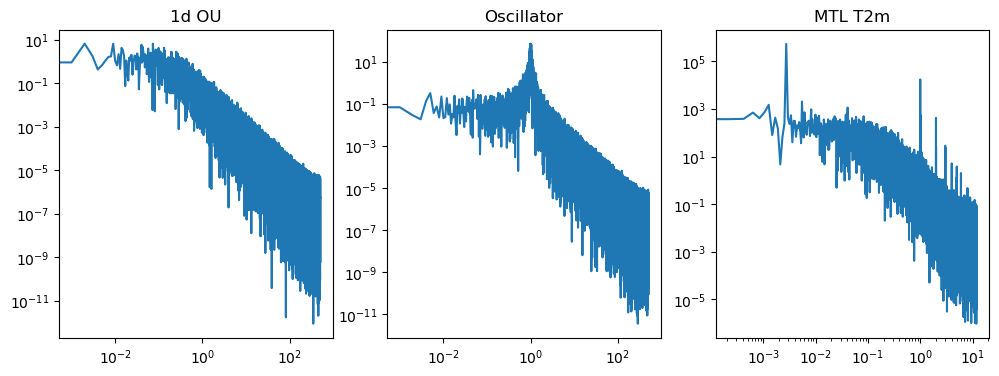

In [3]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
dtl=[1e-3,1e-3,1/24]
titles=['1d OU','Oscillator','MTL T2m']
for i,x in enumerate([x1,x2,x3]):
    X = fft.fft(x)
    dt = dtl[i]
    P = fft.fftshift(X*np.conj(X))*dt*2/len(x)
    f = fft.fftshift(fft.fftfreq(len(x),d=dt))
    axs[i].loglog(f,P)
    axs[i].set_title(titles[i])

# Lab 3.2

1. Write a function that will apply Welch's method to some data and calculate the power spectrum for:
   1. the 1D OU process
   2. 1 component of the stochastic oscillator 
   3. MTLWstation_T2m.nc
2. Add a equivalent spectra for a 1DOU process to the stochastic oscillator and the MTL weather station data. Add error bars to either that spectra or the spectra that you have plotted and determine which peaks in your data are signficant.

In [4]:
def Periodogram(n,
                dn,
                data,
                window=sig.windows.hann,
                d=1/24):
    
    M = int( (len(data)-n) / dn)

    Xm=np.zeros([M,n])
    window = window(n)

    data_A = data-data.mean()

    for i in range(0,M):
        Xm[i] = np.copy(data_A[i*dn:i*dn+n])*window

    Xmf = fft.fft(Xm,axis=-1)
    Pxx = np.mean(np.conj(Xmf)*Xmf,axis=0)
    f = fft.fftfreq(n,d=d)

    f=fft.fftshift(f)
    Pxx=fft.fftshift(Pxx)*d*2/len(Pxx)

    return f,Pxx

In [5]:
def rednoise_spec(
        f,
        s=1,
        tau=1,
):
    S = (2.0*s/tau)/((1/tau)**2+(2*np.pi*f)**2)

    return S

def rednoise_periodic_spec(        
        f,
        s=1,
        tau_relax=2,
        tau_rotate=1
):
    S = (s/tau_relax)* ( 1/((1/tau_relax)**2+(4*np.pi**2*(f-1/tau_rotate)**2))+1/((1/tau_relax)**2+(4*np.pi**2*(f+1/tau_rotate)**2) ) )

    return S


In [6]:
ds2

<xarray.Dataset>
Dimensions:  (dim: 2, t: 1000000)
Coordinates:
  * t        (t) float64 0.0 0.001 0.002 0.003 0.004 ... 1e+03 1e+03 1e+03 1e+03
  * dim      (dim) int64 0 1
Data variables:
    x        (dim, t) float64 ...
Attributes:
    description:     2D OU data
    noise strength:  1
    tau_relax:       1
    tau_rotate:      2

[-500.         -499.96432648 -499.92865297 ...  499.89297945  499.92865297
  499.96432648]


/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-500.         -499.96432648 -499.92865297 ...  499.89297945  499.92865297
  499.96432648]
[-12.         -11.99914384 -11.99828767 ...  11.99743151  11.99828767
  11.99914384]


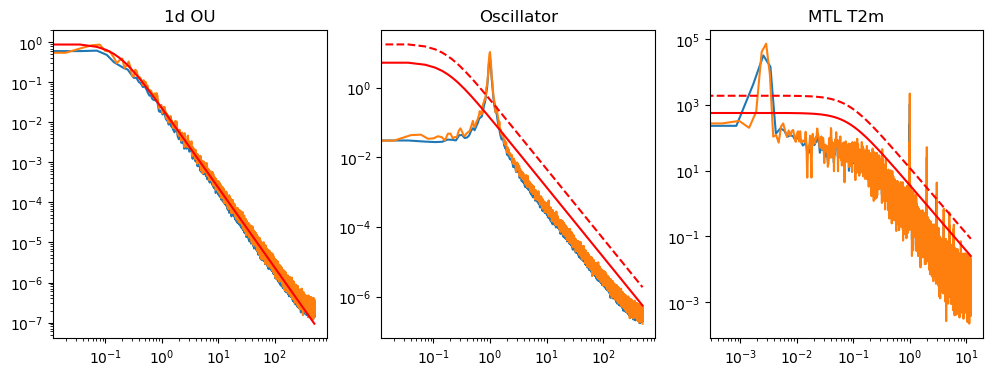

In [7]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
dtl=[1e-3,1e-3,1/24]
titles=['1d OU','Oscillator','MTL T2m']
for i,x in enumerate([x1,x2,x3]):
    dt=dtl[i]

    f,P = Periodogram(
        n=int(24*365*3.2),
        dn=int(24*365*1),
        data=x,
        d=dt
    )

    f2,P2 = sig.welch(x,fs=1/dt,nperseg=5e4)

    print(f)

    axs[i].loglog(f,P)
    axs[i].loglog(f2,P2/2)
    axs[i].set_title(titles[i])

    if i==0:
        axs[i].loglog(f,rednoise_spec(f,tau=1,s=np.var(x1)),'r')
    if i==1:
        axs[i].loglog(f,rednoise_spec(f,tau=1,s=np.var(x2)),'r-')
        axs[i].loglog(f,st.chi2.ppf(0.95,2*10-1)/9*rednoise_spec(f,s=np.var(x2)),'r--')
    if i==2:
        axs[i].loglog(f,rednoise_spec(f,tau=2,s=np.var(x3)),'r-')
        axs[i].loglog(f,st.chi2.ppf(0.95,2*10-1)/9*rednoise_spec(f,s=np.var(x3),tau=2),'r--')


In [8]:
np.var(x3)

143.65819947541985

In [9]:
np.trapz(x=f,y=np.real(P))

109.7691502547955

In [10]:
x3.shape

(113976,)

# Lab 3.3 



In [20]:
def CoherencePhase(n,
                dn,
                data_x,
                data_y,
                window=sig.windows.hann,
                d=1/24):
    
    M = int( (len(data_x)-n) / dn)

    Xm=np.zeros([M,n])
    Ym=np.zeros([M,n])
    window = window(n)

    data_Ax = data_x-data_x.mean()
    data_Ay = data_y-data_y.mean()
    
    for i in range(0,M):
        Xm[i] = np.copy(data_Ax[i*dn:i*dn+n])*window
        Ym[i] = np.copy(data_Ay[i*dn:i*dn+n])*window

    Xmf = fft.fft(Xm,axis=-1)
    Ymf = fft.fft(Ym,axis=-1)
    Pxx = np.mean(np.conj(Xmf)*Xmf,axis=0)
    Pyx = np.mean(np.conj(Xmf)*Ymf,axis=0)
    Pyy = np.mean(np.conj(Ymf)*Ymf,axis=0)

    f = fft.fftfreq(n,d=d)

    cohere = np.abs(Pyx)**2/(Pxx*Pyy)

#    phase = np.angle(Pyx)

    phase = np.arctan2(np.imag(Pyx),np.real(Pyx))

    return fft.fftshift(f),fft.fftshift(cohere),fft.fftshift(phase)

/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


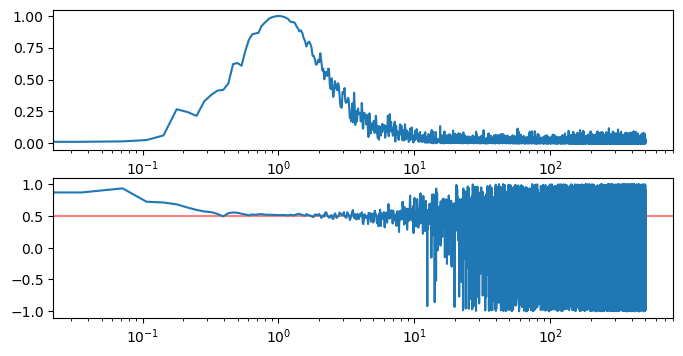

In [24]:
ds2=xr.open_dataset('../data/2DOULong.nc')
x0=ds2.x.isel(dim=0).data
x1=ds2.x.isel(dim=1).data

f,R,P = CoherencePhase(
        n=int(24*365*3.2),
        dn=int(24*365*1),
        data_x=x0,
        data_y=x1,
        d=1e-3
)

fig,axs=plt.subplots(2,1,figsize=(8,4))

axs[0].semilogx(f,R)
axs[1].axhline(0.5,color='r',alpha=0.5)
axs[1].semilogx(f,P/np.pi)


In [13]:
ds_ts=xr.open_dataset('../data/Enso_pdo_timeseries.nc')
enso=ds_ts.enso.data
pdo=ds_ts.pdo.data
time=ds_ts.t.data

In [14]:
np.corrcoef(enso,pdo)

array([[1.       , 0.3763372],
       [0.3763372, 1.       ]])

Text(0.5, 1.0, 'ENSO and PDO indicies')

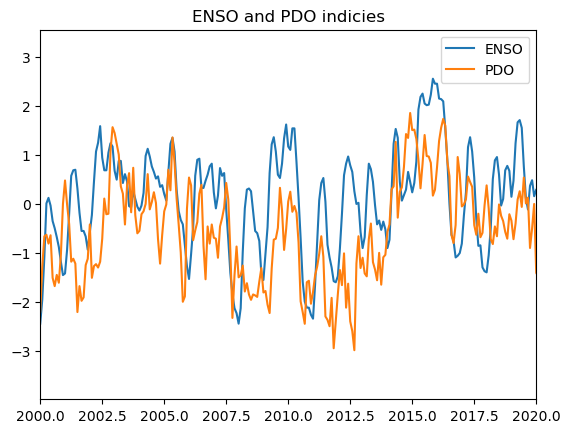

In [15]:
plt.plot(time,enso,label='ENSO')
plt.plot(time,pdo,label='PDO')
plt.xlim([2000,2020])
plt.legend()
plt.title('ENSO and PDO indicies')

/tmp/ipykernel_24005/576144467.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(1/f1,P1)
/tmp/ipykernel_24005/576144467.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(1/f2,P2)


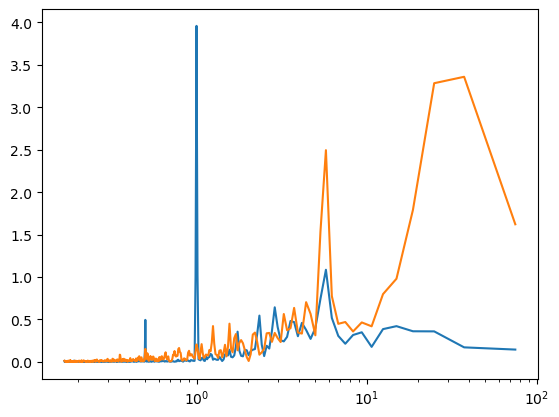

In [16]:
f1,P1 = Periodogram(
    n=int(12*75),
    dn=int(12*25),
    data=enso,
    d=1/12
)

f2,P2 = Periodogram(
    n=int(12*75),
    dn=int(12*25),
    data=pdo,
    d=1/12
)

plt.semilogx(1/f1,P1)
plt.semilogx(1/f2,P2)

/tmp/ipykernel_24005/1547602375.py:11: RuntimeWarning: divide by zero encountered in divide
  axs[0].semilogx(1/f,R)
/tmp/ipykernel_24005/1547602375.py:13: RuntimeWarning: divide by zero encountered in divide
  axs[1].semilogx(1/f,P/np.pi)


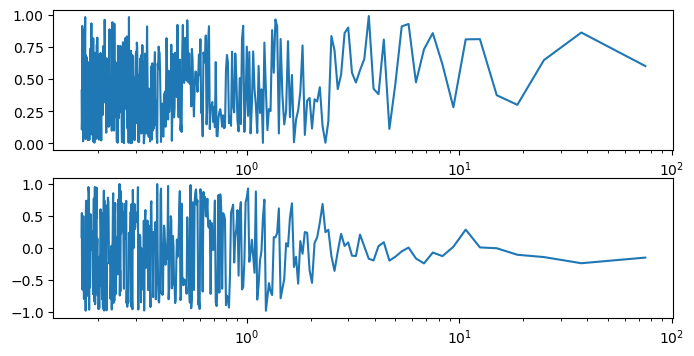

In [17]:
f,R,P = CoherencePhase(
        n=int(12*75),
        dn=int(12*25),
        data_x=enso,
        data_y=pdo,
        d=1/12
)

fig,axs=plt.subplots(2,1,figsize=(8,4))

axs[0].semilogx(1/f,R)
#axs[1].axhline(0.5,color='r',alpha=0.5)
axs[1].semilogx(1/f,P/np.pi)

# Lab 3.4 

In [116]:
def filterAll(data,f1,df):
    b, a = sig.butter(4, f1, 'low', analog=False)
    l = sig.filtfilt(b,a,data,method='gust')
    h = data - l
    b,a = sig.butter(2, [f1-df/2, f1+df/2], btype='bandpass', analog=False)
    p = sig.filtfilt(b,a,data,method='gust')
    return l,h,p

0.08333333333333333 0.020833333333333332
[ 0.00102322  0.         -0.00204644  0.          0.00102322] [ 1.         -3.77637866  5.47458552 -3.60550085  0.9115945 ]


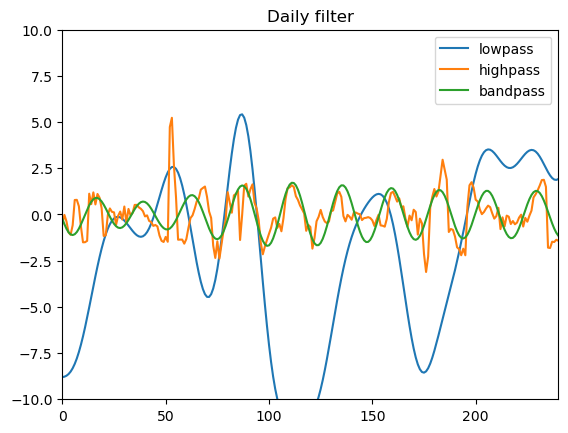

In [115]:
l,h,p = filterAll(x3,1/12,0.25*1/12)
plt.plot(l,label='lowpass')
plt.plot(h,label='highpass')
plt.plot(p,label='bandpass')
plt.xlim([0,24*10])
plt.title('Daily filter')
plt.ylim([-10,10])
plt.legend()

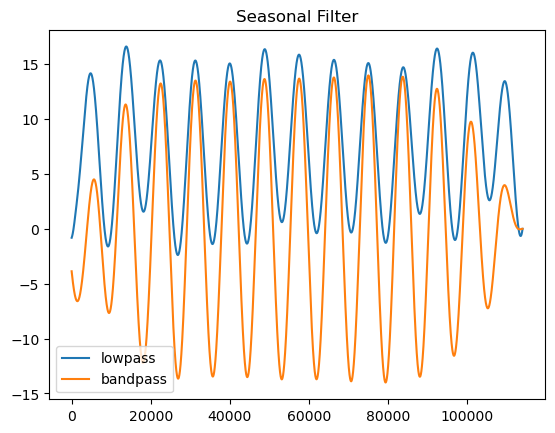

In [117]:
l,h,p = filterAll(x3,1/(24*180),0.25*1/(24*180))
plt.plot(l,label='lowpass')
#plt.plot(h,label='highpass')
plt.plot(p,label='bandpass')
#plt.xlim([0,24*365])
plt.title('Seasonal Filter')
plt.legend()

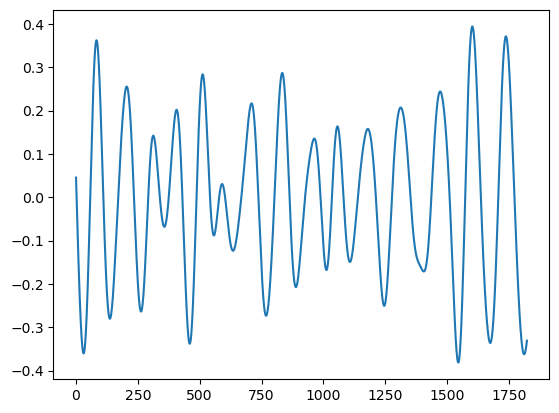

In [138]:
f1 = 1/(5*12)
df = f1/4
# b,a = sig.butter(4, [f1-df/2, f1+df/2], btype='bandpass', analog=False)
b,a = sig.butter(4,f1-df,btype='lowpass')
l = sig.filtfilt(b,a,enso,method='gust')
b,a = sig.butter(4,f1+df,btype='highpass')
h = sig.filtfilt(b,a,enso,method='gust')

plt.plot(enso-h-l,alpha=1)
#plt.plot(h)


# Lab 3.5 

In [18]:
fs = 24
w = 6.

t=np.arange(0,len(x3))/(24*365.25)

freq = np.linspace(1/365, fs/2, 30)
widths=np.logspace(np.log10(6),np.log10(24*7),30)
#widths = w*fs / (2*freq*np.pi)
#widths=np.power
cwtm=np.zeros([len(x3),len(widths)],dtype=np.complex128)

for i,width in enumerate(widths):
    N=len(x3)
    wl=np.conj(sig.morlet2(N,width,w=w))
    W=fft.fft(
        np.conj(
            wl
        )
    )
    ctemp=fft.ifft(W*fft.fft(x3))
    cwtm[:len(x3)//2,i] = ctemp[len(x3)//2:]
    cwtm[len(x3)//2:,i] = ctemp[:len(x3)//2]


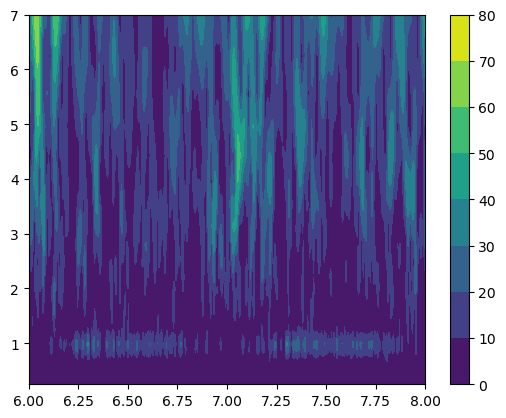

In [19]:
plt.contourf(t,widths/24,np.abs(cwtm).T)
plt.xlim([6,8])
plt.colorbar()
